In [27]:
# standard python imports
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import copy

# pytorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

In [28]:
data = np.load('exp_io_data\CoupledPendula_mean_in7_out7_Tmax2.0_data.npz')
for key, val in data.items():
    print(key)
    exec(key +'=val')

xlist
exp_out_list


In [29]:
x=xlist
y=exp_out_list
#print(y)

In [30]:
print(x.shape)
print(y.shape)

(2000, 14)
(2, 60, 2000, 7, 2)


In [31]:
#y1=y[0:1,29:30,:,:,0:1]
print(y.shape)

#(Nrepeat, Ntimesteps, Nx, output_dim, 2)  <-- 2 = (final position, final velocity)
#y1_np=torch.from_numpy(y1)
#y1=torch.transpose(y1_np,1,2)
#print(y1.shape)
y2=y[0:1,:,0:1000,:,0:1]
#(Nrepeat, Ntimesteps, Nx, output_dim, 2)  <-- 2 = (final position, final velocity)
y2_np=torch.from_numpy(y2)
y2=torch.transpose(y2_np,1,2)
print(y2.shape)
#print(y1.shape)

(2, 60, 2000, 7, 2)
torch.Size([1, 1000, 60, 7, 1])


In [32]:
y3=y2.squeeze(0).squeeze(3)
print(y3.shape)

torch.Size([1000, 60, 7])


In [33]:
y_train=y3[:,5:6,:]
print(y_train.shape)

torch.Size([1000, 1, 7])


In [34]:
x_train=x[0:1000,:]
print(x_train.shape)
print(x)

(1000, 14)
[[0.9515082  0.02859658 0.36347437 ... 0.35507327 0.8292224  0.4047569 ]
 [0.25135255 0.7703726  0.775273   ... 0.14982301 0.15127295 0.7362834 ]
 [0.19514024 0.16856277 0.07611024 ... 0.7874241  0.22519547 0.09913057]
 ...
 [0.47233897 0.5813042  0.5970881  ... 0.4770273  0.8321323  0.0551641 ]
 [0.9792367  0.9304237  0.7407218  ... 0.07495439 0.42210817 0.49420857]
 [0.77542037 0.6565631  0.83288056 ... 0.03630865 0.04533863 0.08364367]]


In [40]:



class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()

        self.layer1 = nn.Linear(14, 14 ,bias=True)
        self.layer2 = nn.Linear(14, 14,bias=True)
        self.layer3 = nn.Linear(14, 14,bias=True)
        self.layer4 = nn.Linear(14, 14,bias=True)
        self.layer5 = nn.Linear(14, 14,bias=True)
        self.layer6 = nn.Linear(14, 7,bias=True)
    def forward(self, x):
        # Max pooling over a (2, 2) window
        
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = x+torch.sigmoid(self.layer1(x))
        x = x+torch.sigmoid(self.layer2(x))
        x = x+torch.sigmoid(self.layer3(x))
        x = x+torch.sigmoid(self.layer4(x))
        x = x+torch.sigmoid(self.layer5(x))
        x = self.layer6(x)
        #x = F.relu(self.layer4(x))
        #x = F.relu(self.layer5(x))
        #x = torch.sigmoid(self.layer6(x))
        return x


net = Net()
print(net)

Net(
  (layer1): Linear(in_features=14, out_features=14, bias=True)
  (layer2): Linear(in_features=14, out_features=14, bias=True)
  (layer3): Linear(in_features=14, out_features=14, bias=True)
  (layer4): Linear(in_features=14, out_features=14, bias=True)
  (layer5): Linear(in_features=14, out_features=14, bias=True)
  (layer6): Linear(in_features=14, out_features=7, bias=True)
)


In [41]:
params = list(net.parameters())
print(len(params))
print(params[0].size())

12
torch.Size([14, 14])


In [42]:
x_data=torch.tensor(x_train)
input = x_data
out = net(input)
print(out)
print(out.shape)

tensor([[-0.4173, -2.3241, -0.3429,  ...,  0.4284, -0.0630, -2.6565],
        [-0.0914, -2.5700, -0.0746,  ...,  0.5564,  0.0607, -2.9695],
        [-0.1508, -2.2861, -0.3025,  ...,  1.0936, -0.0847, -2.6661],
        ...,
        [-0.0849, -2.2377, -0.0667,  ...,  0.8354,  0.2857, -3.1527],
        [ 0.0167, -2.3457, -0.2884,  ...,  0.5538,  0.5991, -3.0559],
        [-0.0377, -2.6025, -0.1882,  ...,  0.8762,  0.1393, -2.9070]],
       grad_fn=<AddmmBackward>)
torch.Size([1000, 7])


In [44]:
net.zero_grad()
out.backward(torch.randn(1000,7))

In [45]:
target=y_train
target_new=target.view(1000,7)
print(target_new.shape)
criterion=nn.MSELoss()
loss=criterion(out,target_new)
print(loss)

torch.Size([1000, 7])
tensor(3.1842, grad_fn=<MseLossBackward>)


In [46]:
import torch.optim as optim
optimizer = torch.optim.Adam(params, lr=0.01, betas=(0.9, 0.999), eps=1e-09, weight_decay=0.1, amsgrad=False)  #adam optimizer
    
for i in range(200):
    optimizer.zero_grad()   # zero the gradient buffers
    output = net(input)
    loss = criterion(output, target_new)
    loss.backward()
    optimizer.step()
    print(loss)


tensor(3.1842, grad_fn=<MseLossBackward>)
tensor(1.9566, grad_fn=<MseLossBackward>)
tensor(1.1480, grad_fn=<MseLossBackward>)
tensor(0.6296, grad_fn=<MseLossBackward>)
tensor(0.3245, grad_fn=<MseLossBackward>)
tensor(0.1886, grad_fn=<MseLossBackward>)
tensor(0.1782, grad_fn=<MseLossBackward>)
tensor(0.2448, grad_fn=<MseLossBackward>)
tensor(0.3383, grad_fn=<MseLossBackward>)
tensor(0.4180, grad_fn=<MseLossBackward>)
tensor(0.4617, grad_fn=<MseLossBackward>)
tensor(0.4660, grad_fn=<MseLossBackward>)
tensor(0.4388, grad_fn=<MseLossBackward>)
tensor(0.3918, grad_fn=<MseLossBackward>)
tensor(0.3359, grad_fn=<MseLossBackward>)
tensor(0.2797, grad_fn=<MseLossBackward>)
tensor(0.2295, grad_fn=<MseLossBackward>)
tensor(0.1897, grad_fn=<MseLossBackward>)
tensor(0.1619, grad_fn=<MseLossBackward>)
tensor(0.1460, grad_fn=<MseLossBackward>)
tensor(0.1403, grad_fn=<MseLossBackward>)
tensor(0.1425, grad_fn=<MseLossBackward>)
tensor(0.1497, grad_fn=<MseLossBackward>)
tensor(0.1590, grad_fn=<MseLossBac

In [47]:
x_test=x[1000:1050,:]
print(x_test.shape)
y1=y[0:1,:,1000:1050,:,0:1]
#(Nrepeat, Ntimesteps, Nx, output_dim, 2)  <-- 2 = (final position, final velocity)
y1_np=torch.from_numpy(y1)
y1=torch.transpose(y1_np,1,2)

(50, 14)


In [48]:
y4=y1.squeeze(0).squeeze(3)
print(y4.shape)

y_test=y4[:,3:4,:]
print(y_test.shape)

torch.Size([50, 60, 7])
torch.Size([50, 1, 7])


In [49]:
x_test=torch.tensor(x_test)
test_out=net(x_test)
#LOSS = criterion(test_out, y_test)
print(test_out)
print(y_test)

tensor([[-4.1258e-06,  2.3505e-02,  1.5161e-02,  1.4878e-02, -2.5270e-02,
         -3.9601e-02, -1.1407e-02],
        [ 6.5706e-02, -9.8589e-03,  1.3467e-02, -1.5102e-02, -1.1037e-01,
         -1.6460e-02, -4.8662e-02],
        [ 3.7872e-02, -1.1803e-01, -4.1998e-02, -3.7610e-02,  1.0223e-03,
          4.3493e-02, -2.6947e-02],
        [ 5.4247e-02, -5.6815e-02,  6.3601e-02, -2.9457e-02, -1.2014e-02,
          1.6632e-02,  2.2102e-02],
        [ 5.5057e-03,  9.6920e-02,  6.0423e-02, -1.0522e-02,  1.6229e-02,
         -8.6386e-02, -1.1255e-03],
        [-7.2185e-02, -1.2077e-01,  1.8374e-02,  2.0195e-01,  6.3456e-02,
          2.7992e-02,  7.3417e-02],
        [ 5.2109e-02,  2.7891e-02, -2.5501e-02, -1.2775e-01, -6.6549e-02,
         -5.5418e-02, -3.0924e-02],
        [-4.2888e-03,  3.4873e-02, -5.6417e-02, -1.7170e-01,  1.0906e-02,
         -2.4731e-02, -1.3658e-01],
        [-5.1081e-02,  1.2648e-01, -7.3276e-04, -1.3847e-02, -1.4533e-02,
         -7.4643e-02, -1.0864e-01],
        [-

Text(0, 0.5, 'y_pred')

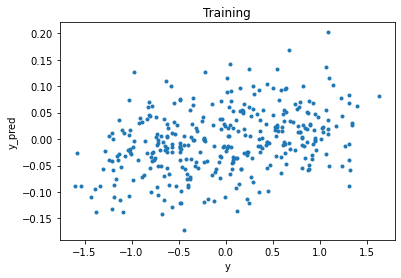

In [52]:
plt.plot(y_test.flatten(), test_out.detach().numpy().flatten(), '.')
plt.title('Training')
plt.xlabel('y')
plt.ylabel('y_pred')

In [19]:

class Net2(nn.Module):

    def __init__(self):
        super(Net2, self).__init__()

        self.layer1 = nn.Linear(14, 120)
        self.layer2 = nn.Linear(120, 120)
        self.layer3 = nn.Linear(120, 120)
        self.layer4 = nn.Linear(120, 84)
        self.layer5 = nn.Linear(84, 42)
        self.layer6 = nn.Linear(42, 7)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = F.relu(self.layer1(x))
        x = x+F.relu(self.layer2(x))
        x = x+F.relu(self.layer3(x))
        x = F.relu(self.layer4(x))
        x = F.tanh(self.layer5(x))
        x = F.relu(self.layer6(x))
        return x


net2 = Net2()
print(net2)

Net2(
  (layer1): Linear(in_features=14, out_features=120, bias=True)
  (layer2): Linear(in_features=120, out_features=120, bias=True)
  (layer3): Linear(in_features=120, out_features=120, bias=True)
  (layer4): Linear(in_features=120, out_features=84, bias=True)
  (layer5): Linear(in_features=84, out_features=42, bias=True)
  (layer6): Linear(in_features=42, out_features=7, bias=True)
)


params2 = list(net2.parameters())
print(len(params2))
print(params2[0].size())

In [20]:
x_data=torch.tensor(x)
input = x_data
out = net2(input)
print(out)
print(out.shape)

tensor([[0.0000, 0.1119, 0.1066,  ..., 0.1546, 0.0000, 0.0040],
        [0.0000, 0.1258, 0.0968,  ..., 0.1616, 0.0032, 0.0222],
        [0.0000, 0.1023, 0.0951,  ..., 0.1067, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0998, 0.0643,  ..., 0.1606, 0.0108, 0.0269],
        [0.0000, 0.1546, 0.1038,  ..., 0.1681, 0.0000, 0.0208],
        [0.0000, 0.1767, 0.1066,  ..., 0.1528, 0.0000, 0.0491]],
       grad_fn=<ReluBackward0>)
torch.Size([2000, 7])


C:\Users\zwdzw\anaconda3\lib\site-packages\torch\nn\functional.py:1794: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [21]:
target=y1[0:1000,:,:]
target_new=target.view(1000,7)

RuntimeError: shape '[1000, 7]' is invalid for input of size 42000

In [ ]:
import torch.optim as optim
optimizer = torch.optim.Adam(params, lr=0.001, betas=(0.9, 0.999), eps=1e-06, weight_decay=0.1, amsgrad=False)  #adam optimizer
    
for i in range(200):
    optimizer.zero_grad()   # zero the gradient buffers
    output = net2(input)
    loss = criterion(output, target_new)
    loss.backward()
    optimizer.step()
    print(loss)
